In [1]:
import sys
sys.path.append("../scripts/")
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose
    
    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        noised_nu = nu + ns[0] * math.sqrt(abs(nu)/time) + ns[1] * math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2] * math.sqrt(abs(nu)/time) + ns[3] * math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)

In [3]:
class Mcl:
    def __init__(self, init_pose, num, motion_noise_stds):
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time):
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
    
    def decition(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T
estimator = Mcl(initial_pose, 100, motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
a = EstimationAgent(0.1, 0.2, 10.0/180*math.pi, estimator)
estimator.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in estimator.particles:
    print(p.pose)

[2.38645089e-02 4.57636430e-05 3.83528420e-03]
[0.02423238 0.00014417 0.01189844]
[0.01965935 0.00022179 0.02256249]
[2.69888879e-02 6.44618860e-05 4.77691141e-03]
[0.01424858 0.00017172 0.02410159]
[0.02286114 0.00022286 0.019496  ]
[0.01539194 0.00013648 0.01773352]
[0.02064159 0.00014064 0.01362704]
[2.19847066e-02 4.60695916e-05 4.19105199e-03]
[0.01902782 0.00014783 0.01553827]
[0.01617032 0.00021604 0.02671841]
[0.01775456 0.00016207 0.01825631]
[0.02051622 0.00028306 0.02759237]
[0.01924142 0.00021326 0.02216573]
[0.02243946 0.00023201 0.02067806]
[0.02264792 0.00023193 0.02048046]
[0.02065088 0.0002466  0.02388199]
[0.02013905 0.00020486 0.02034416]
[0.02425447 0.00033206 0.02737923]
[0.01624201 0.00013742 0.01692089]
[0.01802865 0.0001267  0.01405537]
[0.02091246 0.00019535 0.01868182]
[1.79578336e-02 7.50877727e-05 8.36262735e-03]
[0.01730985 0.00019413 0.02242907]
[0.02249824 0.0002599  0.02310286]
[0.02175249 0.00022343 0.02054266]
[0.01933176 0.00025389 0.02626517]
[0.0239

<IPython.core.display.Javascript object>


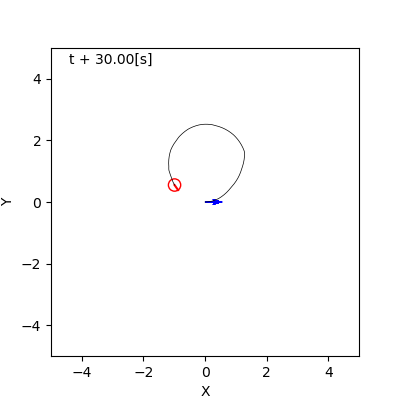

In [6]:
def trial(motion_noise_stds):
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(initial_pose, 100, motion_noise_stds)
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=None, agent=circling, color="red")
    world.append(r)
    
    world.draw()

trial({"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})